In [1]:
!pip3 install handyspark

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from handyspark import *

In [3]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [4]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from pyspark.sql import SparkSession

In [7]:
#from LC_Helper import vectorizerFunction, SmoteSampling

In [8]:
spark = SparkSession\
    .builder\
    .appName("LC_Baseline_Model")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-2/")\
    .getOrCreate()

In [9]:
df = spark.sql("SELECT * FROM default.LC_Smote_K_3")

In [10]:
#Creating list of categorical and numeric features
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]

In [11]:
df = df.dropna()

In [12]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'is_default'])

In [13]:
train = df.sampleBy("is_default", fractions={0: 0.8, 1: 0.8}, seed=10)

In [14]:
test = df.subtract(train)

Creating Model Pipeline

In [15]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='is_default', maxIter=10, regParam=0.1, elasticNetParam=0.1)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [16]:
pipelineModel = make_pipeline(train)

In [17]:
for c in test.columns:
    test = test.withColumn(c, test[c].cast("float"))

In [18]:
df_model = pipelineModel.transform(test)

In [19]:
input_data = df_model.rdd.map(lambda x: (x["is_default"], x["prediction"], float(x["probability"][1])))

In [20]:
predictions = spark.createDataFrame(input_data, ["is_default", "prediction", "probability"])

In [21]:
predictions.dtypes

[('is_default', 'double'), ('prediction', 'double'), ('probability', 'double')]

In [22]:
df_model.select()

DataFrame[]

#### Baseline Model

In [23]:
df_model.select("is_default", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|87334|
|       1.0|26668|
+----------+-----+



In [24]:
df_model.select("is_default", "prediction").groupby('is_default').count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|       1.0|53798|
|       0.0|60204|
+----------+-----+



Model Evaluation

In [25]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default", rawPredictionCol="prediction")

In [26]:
auroc = evaluator.evaluate(df_model, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(df_model, {evaluator.metricName: "areaUnderPR"})

In [27]:
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.5361
Area under PR Curve: 0.5209


In [28]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(df_model, scoreCol='probability', labelCol='is_default')

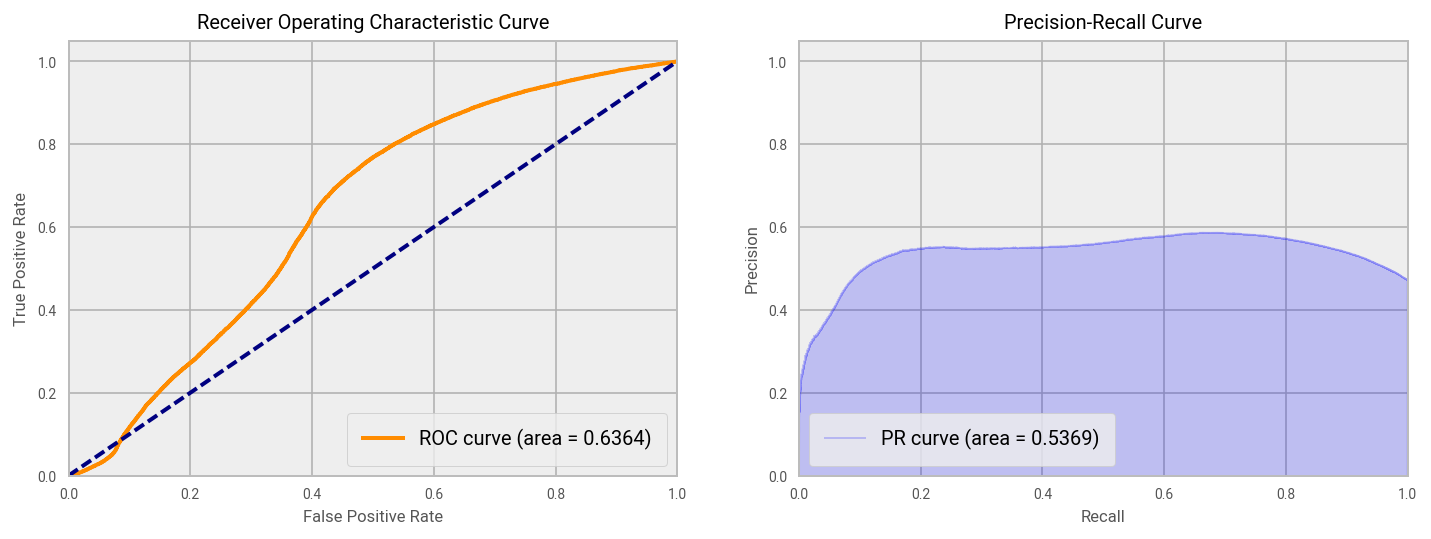

In [29]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [30]:
# And get the confusion matrix for any threshold we want
cm = bcm.print_confusion_matrix(.50)

In [31]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

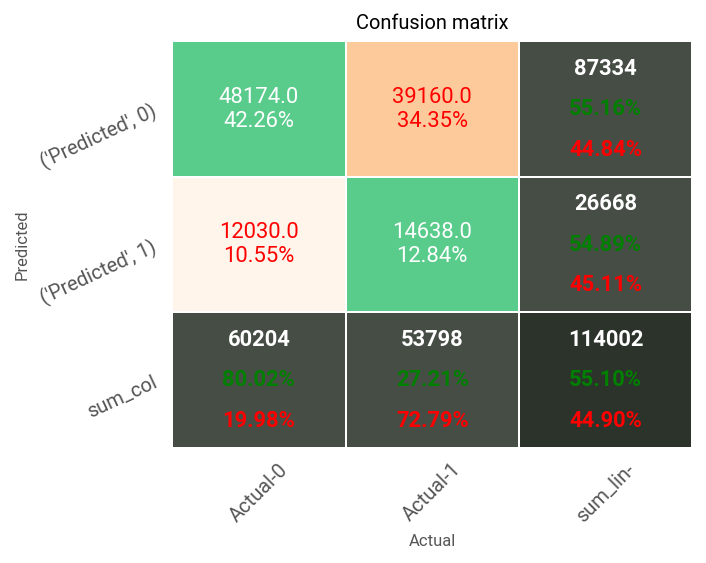

In [32]:
pretty_plot_confusion_matrix(cm, figsize=[5,4])
plt.show()

In [56]:
#We assign a cost to each of the four items in the quadrant
fp_cost = 0
fn_cost = 150
tp_cost = 150
tn_cost = 0

In [57]:
#We assign a financial gain to true positives
revenue_per_loan = 200
support_unit_cost = 20
marketing_unit_cost = 75

In [71]:
def campaign_outcome_all(cm, fn_cost, tp_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tp = cm.iloc[1,1]
    num_tn = cm.iloc[0,0]
    num_fp = cm.iloc[1,0]
    num_fn = cm.iloc[0,1]
    
    #Calculate total costs:
    
    #Revenue:
    rev = (num_tn+num_fp)*revenue_per_loan
    
    #Customer Support & Marketing Costs:
    support_costs = (num_tn+num_fp)*support_unit_cost
    marketing_costs = (num_tn+num_fp)*marketing_unit_cost
    #True Positive Costs 
    tp_expenses = num_tp * tp_cost
    #False Negative Costs
    fn_expenses = num_fn * fn_cost
    #Total additional expense if you service loan to person who will eventually default:
    total_costs = support_costs + marketing_costs + tp_expenses + fn_expenses
    
    #Profit:
    campaign_profit = rev - total_costs
    
    print("The estimate campaign outcome with all customers is: ", campaign_profit, " with Decision Threshold: ", thres)
    return campaign_profit

In [72]:
def campaign_outcome_predicted(cm, fn_cost, tn_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tn = cm.iloc[0,0]
    num_fn = cm.iloc[0,1]
    #Calculate total costs:
    
    #Revenue:
    rev = (num_tn)*revenue_per_loan
    
    #Customer Support & Marketing Costs:
    support_costs = (num_tn)*support_unit_cost
    marketing_costs = (num_tn)*marketing_unit_cost
    #False Negative Costs
    fn_expenses = num_fn * fn_cost
    #Total costs:
    total_costs = support_costs + marketing_costs + fn_expenses
    
    #Profit:
    campaign_profit = rev - total_costs
    
    print("The estimate campaign outcome with selected customers is: ", campaign_profit, " with Decision Threshold: ", thres)
    return campaign_profit

In [73]:
campaign_outcome_all(cm, fn_cost, tp_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, 0.5)

The estimate campaign outcome with all customers is:  5169870.0  with Decision Threshold:  0.5


5169870.0

In [74]:
campaign_outcome_predicted(cm, fn_cost, tn_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, 0.5)

The estimate campaign outcome with selected customers is:  3253770.0  with Decision Threshold:  0.5


3253770.0

In [75]:
gains_all = []
gains_predicted = []
for thres in np.arange(0,1,0.2):
    campaign_gain_all = campaign_outcome_all(cm, fn_cost, tp_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, thres)
    campaign_gain_predicted = campaign_outcome_predicted(cm, fn_cost, tn_cost, revenue_per_loan, support_unit_cost, marketing_unit_cost, thres)
    gains_all.append((thres, campaign_gain_all))
    gains_predicted.append((thres, campaign_gain_predicted))

The estimate campaign outcome with all customers is:  -17100300.0  with Decision Threshold:  0.0
The estimate campaign outcome with selected customers is:  -9030600.0  with Decision Threshold:  0.0
The estimate campaign outcome with all customers is:  -17064090.0  with Decision Threshold:  0.2
The estimate campaign outcome with selected customers is:  -9002295.0  with Decision Threshold:  0.2
The estimate campaign outcome with all customers is:  -15880125.0  with Decision Threshold:  0.4
The estimate campaign outcome with selected customers is:  -8011365.0  with Decision Threshold:  0.4
The estimate campaign outcome with all customers is:  11970210.0  with Decision Threshold:  0.6000000000000001
The estimate campaign outcome with selected customers is:  6321420.0  with Decision Threshold:  0.6000000000000001
The estimate campaign outcome with all customers is:  11970210.0  with Decision Threshold:  0.8
The estimate campaign outcome with selected customers is:  6321420.0  with Decision 

In [76]:
df_all = pd.DataFrame(gains_all, columns=['Threshold', 'NetCampaignContribution_ALL']).set_index('Threshold')
df_predicted = pd.DataFrame(gains_predicted, columns=['Threshold', 'NetCampaignContribution_SELECTED']).set_index('Threshold')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


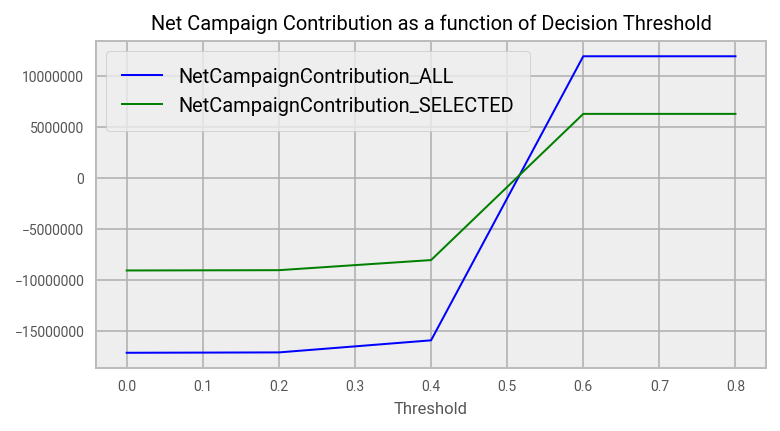

In [77]:
f, ax = plt.subplots(1, figsize=(6,3))
df_all.plot(ax=ax, color='b', markeredgewidth=10)
df_predicted.plot(ax=ax, color='g', markeredgewidth=10)
xs = np.linspace(0, 1, 0.2, 200)
plt.hlines(y=40, xmin=0, xmax=len(xs), color='r', linestyles='--', lw=2)
ax.set_title("Net Campaign Contribution as a function of Decision Threshold")
plt.ticklabel_format(style = 'plain')
plt.show()

In [ ]:
#Saving the predictions

In [65]:
predictions\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_predictions'
)

In [66]:
train\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_train'
)

In [67]:
test\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_test'
)

In [68]:
#Saving pipeline to S3:
pipelineModel.write().overwrite().save("s3a://demo-aws-2/datalake/pdefusco/pipeline")

In [ ]:
spark.stop()

In [69]:
df_all

,NetCampaignContribution_ALL
Threshold,
0.0,-1748280.0
0.2,-1748280.0
0.4,-1748280.0
0.6,-1748280.0
0.8,-1748280.0


In [70]:
df_predicted

,NetCampaignContribution_SELECTED
Threshold,
0.0,0.0
0.2,7005.0
0.4,301485.0
0.6,-1748280.0
0.8,-1748280.0


In [78]:
cm_random = bcm.print_confusion_matrix(.50)

In [84]:
cm_random.to_csv("cm_random.csv", index=False)